# Test de rectangularisation fruste

_Jérôme Lacaille_ (20/12/2024)

In [1]:
# Import minimal.

import os
import numpy as np
import pandas as pd
import tabata as tbt
import matplotlib.pyplot as plt
import ipywidgets as widgets
%matplotlib inline



## 1. Renormalisation des données.

In [2]:
# Chargement des données.
datadir = "../Data/cleaned/"
final_file = datadir + "AFL1EB_cleaned_final.h5"
norm_file = datadir + "AFL1EB_normed_alt.h5"
dsc = tbt.Opset(final_file)
dsc

OPSET '../Data/cleaned/AFL1EB_cleaned_final.h5' de 47 signaux.
        position courante : sigpos  = 0
        variable courante : colname = ALT[m]
        phase surlignée   : phase   = None

In [3]:
dsc.plot()

In [5]:
# Ajout d'une référence normalisée à utiliser pour la transformation.

dsn1 = tbt.Opset(norm_file).clean()
for df in dsc:
    alt = df["ALT[m]"]
    max_alt = np.max(alt)
    min_alt = np.min(alt)
    altn = (alt-min_alt)/(max_alt-min_alt)
    df["ALTN[-]"] = altn
    dsn1.put(df)
dsn1

OPSET '../Data/cleaned/AFL1EB_normed_alt.h5' de 47 signaux.
        position courante : sigpos  = 46
        variable courante : colname = ALT[m]
        phase surlignée   : phase   = None

In [6]:
dsn1.plot()

In [7]:
df = dsn1.df
x = df["ALTN[-]"]
x.index

DatetimeIndex(['2013-02-20 02:58:00', '2013-02-20 02:58:01',
               '2013-02-20 02:58:02', '2013-02-20 02:58:03',
               '2013-02-20 02:58:04', '2013-02-20 02:58:05',
               '2013-02-20 02:58:06', '2013-02-20 02:58:07',
               '2013-02-20 02:58:08', '2013-02-20 02:58:09',
               ...
               '2013-02-20 05:33:17', '2013-02-20 05:33:18',
               '2013-02-20 05:33:19', '2013-02-20 05:33:20',
               '2013-02-20 05:33:21', '2013-02-20 05:33:22',
               '2013-02-20 05:33:23', '2013-02-20 05:33:24',
               '2013-02-20 05:33:25', '2013-02-20 05:33:26'],
              dtype='datetime64[ns]', name='record_51', length=9327, freq='s')

In [8]:
df.index.name

'record_51'

In [22]:
t0 = x.index[0].value
t1 = x.index[-1].value
t = pd.to_datetime(np.linspace(t0,t1,50))
y = np.interp(t,x.index,x.values)


len(x)=9327
len(y)=50


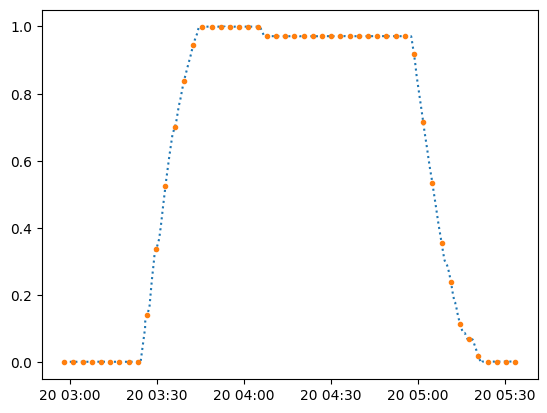

In [24]:
plt.plot(x,':')
plt.plot(t,y,'.')
print(f"len(x)={len(x)}")
print(f"len(y)={len(y)}")

In [ ]:
# Création d'une interpolation linéaire.

w = len(dsc.df.columns)
n = len(dsc)
N = 50
Y = []
M = []
Cols = []
for df in dsn1:
    x = df["ALTN[-]"]
    t0 = x.index[0].value
    t1 = x.index[-1].value
    M.append((x.index[0],x.index[-1]))
    t = pd.to_datetime(np.linspace(t0,t1,N))
    y = np.interp(t,x.index,x.values)
    Y.append(y)
    Cols.append(df.index.name)
ALT = pd.DataFrame(data=np.vstack(Y).T,columns=Cols)

In [41]:
ALT.head()

,record_00,record_01,record_02,record_03,record_04,record_05,record_11,record_12,record_13,record_14,...,record_42,record_43,record_44,record_45,record_46,record_47,record_48,record_49,record_50,record_51
0,0.000470,0.008315,0.001134,0.003082,0.003842,0.003980,0.003732,0.001595,0.004914,0.002620,...,0.002276,0.002302,0.003939,0.001139,0.003540,0.003756,0.001682,0.001393,0.001800,0.001937
1,0.000470,0.008432,0.001247,0.002972,0.003705,0.004209,0.003732,0.001481,0.004935,0.002620,...,0.002200,0.002302,0.003684,0.001253,0.003319,0.003961,0.001923,0.001741,0.001929,0.001937
2,0.000257,0.008384,0.001134,0.002972,0.003568,0.003980,0.003732,0.001709,0.005031,0.002620,...,0.002276,0.002302,0.003811,0.001253,0.003540,0.003756,0.001923,0.001625,0.001929,0.001937
3,0.000352,0.008432,0.001474,0.003192,0.003772,0.003980,0.003491,0.001709,0.005031,0.002620,...,0.002390,0.002412,0.003430,0.001367,0.003983,0.004087,0.002163,0.001277,0.001929,0.002051
4,0.000587,0.008432,0.001360,0.002092,0.003705,0.003980,0.003732,0.001709,0.005031,0.002734,...,0.001742,0.001754,0.003684,0.001025,0.003761,0.040271,0.002043,0.002205,0.001929,0.002279


In [48]:
M

[(Timestamp('2012-07-10 11:08:00'), Timestamp('2012-07-10 13:11:48')),
 (Timestamp('2012-07-10 14:10:00'), Timestamp('2012-07-10 16:14:18')),
 (Timestamp('2012-07-27 03:40:00'), Timestamp('2012-07-27 05:37:21')),
 (Timestamp('2012-07-27 06:34:00'), Timestamp('2012-07-27 08:21:36')),
 (Timestamp('2012-08-03 01:24:00'), Timestamp('2012-08-03 02:44:59')),
 (Timestamp('2012-08-03 03:25:00'), Timestamp('2012-08-03 04:23:29')),
 (Timestamp('2013-01-19 20:25:00'), Timestamp('2013-01-19 22:22:06')),
 (Timestamp('2013-01-29 03:58:00'), Timestamp('2013-01-29 05:56:19')),
 (Timestamp('2013-01-29 06:38:00'), Timestamp('2013-01-29 08:35:45')),
 (Timestamp('2013-02-06 02:49:00'), Timestamp('2013-02-06 05:00:25')),
 (Timestamp('2013-02-06 06:10:00'), Timestamp('2013-02-06 08:13:29')),
 (Timestamp('2013-02-06 10:26:00'), Timestamp('2013-02-06 12:29:40')),
 (Timestamp('2013-02-06 13:10:00'), Timestamp('2013-02-06 15:22:48')),
 (Timestamp('2013-02-06 19:48:00'), Timestamp('2013-02-06 21:59:26')),
 (Time